In [256]:
import pandas as pd
import numpy as np

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from textblob.blob import TextBlob
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
import textstat

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB


nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.tree import Tree
from nltk import ne_chunk

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennylee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jennylee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jennylee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jennylee/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jennylee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jennylee/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/jennylee/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Load Data

In [2]:
fake_news = pd.read_csv("DataSet_Misinfo_FAKE.csv").rename(columns={"Unnamed: 0":"news_ID"})
display(fake_news.head())

,news_ID,text
0,0,Donald Trump just couldn t wish all Americans ...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,"On Friday, it was revealed that former Milwauk..."
3,3,"On Christmas day, Donald Trump announced that ..."
4,4,Pope Francis used his annual Christmas Day mes...


In [3]:
true_news = pd.read_csv("DataSet_Misinfo_TRUE.csv").rename(columns={"Unnamed: 0":"news_ID"})
display(true_news.head())

,news_ID,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...


In [4]:
def cleanup_df(df, genre):
    original_rows = df.shape[0]
    df["text"] = df["text"].str.replace("[\n\r]", " ")
    df["text"] = df["text"].str.replace("\(@[\w]+\)", "")
    df_need_clean = df[df.isna().any(axis=1)]
    df = df.drop_duplicates(subset=["text"], keep="last")
    print(f"{original_rows - df.shape[0]} duplicated rows present in {genre} news dataset.")
    duplicated_rows = df.shape[0]
    if len(df_need_clean) >= 1:
        df = df[df['text'].notna()]
    print(f"{duplicated_rows - df.shape[0]} NaN row removed.\nTotal number of rows remaining are: {df.shape[0]} rows.")
    display(df.head())
    return df

In [5]:
true_news = cleanup_df(true_news, "true")
fake_news = cleanup_df(fake_news, "fake")

/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_20000/2217677230.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace("[\n\r]", " ")


448 duplicated rows present in true news dataset.
1 NaN row removed.
Total number of rows remaining are: 34526 rows.


/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_20000/2217677230.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace("\(@[\w]+\)", "")


,news_ID,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...


/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_20000/2217677230.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace("[\n\r]", " ")
/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_20000/2217677230.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace("\(@[\w]+\)", "")


9564 duplicated rows present in fake news dataset.
0 NaN row removed.
Total number of rows remaining are: 34078 rows.


,news_ID,text
0,0,Donald Trump just couldn t wish all Americans ...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,"On Friday, it was revealed that former Milwauk..."
3,3,"On Christmas day, Donald Trump announced that ..."
4,4,Pope Francis used his annual Christmas Day mes...


---

## Exploration

In [6]:
def assign_readability_time_scores(df):
    readability_score = lambda x: textstat.flesch_reading_ease(str(x["text"]))
    df["readability_score"] = df.apply(readability_score, axis=1)
    reading_time = lambda x: textstat.reading_time(str(x["text"]), ms_per_char=14.69)
    df["reading_time"] = df.apply(reading_time, axis=1)
    return df

fake_news = assign_readability_time_scores(fake_news)
true_news = assign_readability_time_scores(true_news)
display(fake_news.head())
display(true_news.head())

,news_ID,text,readability_score,reading_time
0,0,Donald Trump just couldn t wish all Americans ...,71.65,32.17
1,1,House Intelligence Committee Chairman Devin Nu...,62.78,23.36
2,2,"On Friday, it was revealed that former Milwauk...",72.46,41.09
3,3,"On Christmas day, Donald Trump announced that ...",62.38,32.33
4,4,Pope Francis used his annual Christmas Day mes...,67.08,28.10


,news_ID,text,readability_score,reading_time
0,0,The head of a conservative Republican faction ...,51.58,57.10
1,1,Transgender people will be allowed for the fir...,40.69,31.47
2,2,The special counsel investigation of links bet...,58.01,33.85
3,3,Trump campaign adviser George Papadopoulos tol...,51.58,30.33
4,4,President Donald Trump called on the U.S. Post...,63.09,63.36


In [7]:
fake_sample = fake_news.sample(n=34000)
true_sample = true_news.sample(n=34000)

In [8]:
def count_news_length(df, genre):
    df["count"] = df["text"].str.len()
    mean_count = df["count"].mean()
    print(f"Mean number of characters in a {genre} news article is {'%02d' % mean_count} characters.")
    return df

fake_sample = count_news_length(fake_sample, "fake")
display(fake_sample.head())
true_news = count_news_length(true_sample, "true")
display(true_sample.head())

Mean number of characters in a fake news article is 2565 characters.


,news_ID,text,readability_score,reading_time,count
37210,37992,"Throughout the 2000s the US, with the assistan...",30.91,5.80,465
3166,3166,Donald Trump tweeted out yet another defense o...,56.49,56.63,4682
17375,17855,San Juan Mayor Carmen Yulin Cruz tore a book f...,56.08,26.35,2190
12462,12781,TWITTER IS ABUZZ OVER THE FLY THAT LANDED ON H...,87.35,3.38,283
18762,19296,Thomas article can be read below:My dad calle...,78.75,27.34,2267


Mean number of characters in a true news article is 3243 characters.


,news_ID,text,readability_score,reading_time,count
13937,13937,The death toll in a militant attack on a mosqu...,65.39,1.97,164
22032,22032,President Donald Trump won the 2016 election p...,56.18,31.91,2599
28347,28347,"From the “it ain’t gonna happen” department, B...",56.18,24.43,2016
17174,17174,Two men were injured in a drive-by shooting at...,58.52,12.53,1025
620,620,Republican lawmakers are pressing forward with...,46.57,11.77,947


---

## Data Cleaning & NLP Processing

In [47]:
# Derived from: https://gist.github.com/sebleier/554280
extend_stopwords = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz", "mr"]
print(f"{len(extend_stopwords)} new number of stopwords are added.")

1161 new number of stopwords are added.


In [11]:
def tag_mapper(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return wordnet.NOUN
    
lemmatizer = WordNetLemmatizer()
stopwords_ls = set(stopwords.words("english"))
stopwords_ls.update(extend_stopwords)

def remove_stopwords_and_lemmatize(article):
    words = pos_tag(word_tokenize(article))
    filtered_article = [lemmatizer.lemmatize(word, pos=tag_mapper(tag)) for word, tag in words if (word.lower() not in stopwords_ls)]
    full_article = (" ".join(filtered_article))
    return full_article

fake_sample["filtered_text"] = fake_sample["text"].apply(lambda x: remove_stopwords_and_lemmatize(x))
true_sample["filtered_text"] = true_sample["text"].apply(lambda x: remove_stopwords_and_lemmatize(x))
display(fake_sample.head())
display(true_sample.head())

,news_ID,text,readability_score,reading_time,count,filtered_text
37210,37992,"Throughout the 2000s the US, with the assistan...",30.91,5.80,465,"2000s , assistance Baltic state , Poland , Swe..."
3166,3166,Donald Trump tweeted out yet another defense o...,56.49,56.63,4682,"Donald Trump tweet defense Putin Wednesday , f..."
17375,17855,San Juan Mayor Carmen Yulin Cruz tore a book f...,56.08,26.35,2190,San Juan Mayor Carmen Yulin Cruz tear book nas...
12462,12781,TWITTER IS ABUZZ OVER THE FLY THAT LANDED ON H...,87.35,3.38,283,TWITTER ABUZZ FLY LANDED HILLARY FACE : strang...
18762,19296,Thomas article can be read below:My dad calle...,78.75,27.34,2267,Thomas article read : dad call Martin Luther K...


,news_ID,text,readability_score,reading_time,count,filtered_text
13937,13937,The death toll in a militant attack on a mosqu...,65.39,1.97,164,death toll militant attack mosque Egypt north ...
22032,22032,President Donald Trump won the 2016 election p...,56.18,31.91,2599,President Donald Trump 2016 election promise d...
28347,28347,"From the “it ain’t gonna happen” department, B...",56.18,24.43,2016,"“ ’ gon happen ” department , Baltimore Ravens..."
17174,17174,Two men were injured in a drive-by shooting at...,58.52,12.53,1025,men injure drive-by shooting South Africa Cape...
620,620,Republican lawmakers are pressing forward with...,46.57,11.77,947,Republican lawmaker press forward investigatio...


In [12]:
sid = SentimentIntensityAnalyzer()

def calculate_subjectivity(article):
    return TextBlob(article).sentiment.subjectivity

def nlp_analysis_workflow(df):
    df["Subjectivity"] = df["filtered_text"].apply(calculate_subjectivity)
    sentiment_scores = df["filtered_text"].apply(sid.polarity_scores)
    df["Negative"] = sentiment_scores.apply(lambda x: x['neg'])
    df["Positive"] = sentiment_scores.apply(lambda x: x['pos'])
    df["Neutral"] = sentiment_scores.apply(lambda x: x['neu'])
    df["Compound"] = sentiment_scores.apply(lambda x: x['compound'])
    df["Subjectivity"] = df["filtered_text"].apply(calculate_subjectivity)
    return df

fake_sample = nlp_analysis_workflow(fake_sample)
true_sample = nlp_analysis_workflow(true_sample)
display(fake_sample.head())
display(true_sample.head())

,news_ID,text,readability_score,reading_time,count,filtered_text,Subjectivity,Negative,Positive,Neutral,Compound
37210,37992,"Throughout the 2000s the US, with the assistan...",30.91,5.80,465,"2000s , assistance Baltic state , Poland , Swe...",0.322222,0.245,0.250,0.505,-0.1779
3166,3166,Donald Trump tweeted out yet another defense o...,56.49,56.63,4682,"Donald Trump tweet defense Putin Wednesday , f...",0.527758,0.109,0.186,0.705,0.9854
17375,17855,San Juan Mayor Carmen Yulin Cruz tore a book f...,56.08,26.35,2190,San Juan Mayor Carmen Yulin Cruz tear book nas...,0.623861,0.244,0.100,0.656,-0.9869
12462,12781,TWITTER IS ABUZZ OVER THE FLY THAT LANDED ON H...,87.35,3.38,283,TWITTER ABUZZ FLY LANDED HILLARY FACE : strang...,0.666667,0.208,0.000,0.792,-0.6093
18762,19296,Thomas article can be read below:My dad calle...,78.75,27.34,2267,Thomas article read : dad call Martin Luther K...,0.348958,0.314,0.056,0.630,-0.9965


,news_ID,text,readability_score,reading_time,count,filtered_text,Subjectivity,Negative,Positive,Neutral,Compound
13937,13937,The death toll in a militant attack on a mosqu...,65.39,1.97,164,death toll militant attack mosque Egypt north ...,0.000000,0.292,0.000,0.708,-0.7906
22032,22032,President Donald Trump won the 2016 election p...,56.18,31.91,2599,President Donald Trump 2016 election promise d...,0.225556,0.071,0.149,0.781,0.9738
28347,28347,"From the “it ain’t gonna happen” department, B...",56.18,24.43,2016,"“ ’ gon happen ” department , Baltimore Ravens...",0.232843,0.151,0.077,0.772,-0.8860
17174,17174,Two men were injured in a drive-by shooting at...,58.52,12.53,1025,men injure drive-by shooting South Africa Cape...,0.238095,0.079,0.026,0.894,-0.5859
620,620,Republican lawmakers are pressing forward with...,46.57,11.77,947,Republican lawmaker press forward investigatio...,0.413333,0.016,0.156,0.828,0.9153


In [13]:
nlp_summary_df = pd.DataFrame()
nlp_summary_df["News Type"] = ["Fake News", "True News"]
nlp_summary_df["Positive"] = [fake_sample["Positive"].mean(), true_sample["Positive"].mean()]
nlp_summary_df["Negative"] = [fake_sample["Negative"].mean(), true_sample["Negative"].mean()]
nlp_summary_df["Compound"] = [fake_sample["Compound"].mean(), true_sample["Compound"].mean()]
nlp_summary_df["Neutral"] = [fake_sample["Neutral"].mean(), true_sample["Neutral"].mean()]
nlp_summary_df["Subjectivity"] = [fake_sample["Subjectivity"].mean(), true_sample["Subjectivity"].mean()]
display(nlp_summary_df)

,News Type,Positive,Negative,Compound,Neutral,Subjectivity
0,Fake News,0.136882,0.165019,-0.147257,0.697949,0.407425
1,True News,0.136830,0.130691,0.065437,0.732450,0.373503


Now displaying WordCloud visualization for fake news.


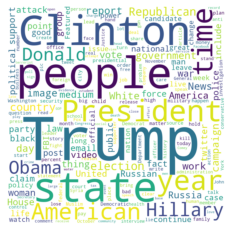

Now displaying WordCloud visualization for true news.


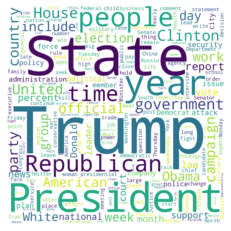

In [14]:
def generate_wordcloud(df, file_name):
    word_text = " ".join(article for article in df.filtered_text)

    word_cloud = WordCloud(width=1000, height=1000, random_state=1,
                          background_color="white", collocations=False,
                          stopwords=stopwords_ls).generate(word_text)
    print(f"Now displaying WordCloud visualization for {file_name} news.")
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'images/{file_name}_wordcloud.png')
    plt.show()
    
generate_wordcloud(fake_sample, "fake")
generate_wordcloud(true_sample, "true")

### Top 20 Words Mentioned

In [97]:
def get_top_20_words(df, column_name="filtered_text", n=20):
    cv = CountVectorizer(stop_words = 'english')
    vec = cv.fit(df[column_name])
    bag_of_words = vec.transform(df[column_name])
    sum_words = bag_of_words.sum(axis=0)
    calculate_frequency = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    calculate_frequency =sorted(calculate_frequency, key = lambda x: x[1], reverse=True)
    top_20_words_dict = calculate_frequency[:n]
    df_return = pd.DataFrame(top_20_words_dict, columns=["Word", "Frequency"])
    return df_return
    
true_top_20_words = get_top_20_words(true_sample)
fake_top_20_words = get_top_20_words(fake_sample)

In [59]:
display(true_top_20_words.head())
display(fake_top_20_words.head())

,Word,Frequency
0,trump,95451
1,mr,63282
2,president,47766
3,year,44798
4,state,44042


,Word,Frequency
0,trump,89268
1,people,39169
2,clinton,33598
3,president,30314
4,state,26287


### Most Mentioned  & Countries

In [92]:
def count_name(article):
    nltk_results = pos_tag(word_tokenize(article))
    all_name_list = []
    for result in nltk_results:
        if "NNP" in result:
            name = result[0]
            all_name_list.append(name)
    all_name_column = (" ".join(all_name_list))
    return all_name_column

fake_sample["names"] = fake_sample["filtered_text"].apply(lambda x: count_name(x))
true_sample["names"] = true_sample["filtered_text"].apply(lambda x: count_name(x))
display(fake_sample.head())
display(true_sample.head())

,news_ID,text,readability_score,reading_time,count,filtered_text,Subjectivity,Negative,Positive,Neutral,Compound,label,names
37210,37992,"Throughout the 2000s the US, with the assistan...",30.91,5.80,465,"2000s , assistance Baltic state , Poland , Swe...",0.322222,0.245,0.250,0.505,-0.1779,1,Baltic Poland Sweden “ Russia “ ” Russia Europ...
3166,3166,Donald Trump tweeted out yet another defense o...,56.49,56.63,4682,"Donald Trump tweet defense Putin Wednesday , f...",0.527758,0.109,0.186,0.705,0.9854,1,Donald Trump Putin Wednesday Vladimir Putin Do...
17375,17855,San Juan Mayor Carmen Yulin Cruz tore a book f...,56.08,26.35,2190,San Juan Mayor Carmen Yulin Cruz tear book nas...,0.623861,0.244,0.100,0.656,-0.9869,1,San Juan Mayor Carmen Yulin Cruz Democrat Wedn...
12462,12781,TWITTER IS ABUZZ OVER THE FLY THAT LANDED ON H...,87.35,3.38,283,TWITTER ABUZZ FLY LANDED HILLARY FACE : strang...,0.666667,0.208,0.000,0.792,-0.6093,1,TWITTER ABUZZ FLY LANDED HILLARY FACE Obama Hi...
18762,19296,Thomas article can be read below:My dad calle...,78.75,27.34,2267,Thomas article read : dad call Martin Luther K...,0.348958,0.314,0.056,0.630,-0.9965,1,Thomas Martin Luther King Dr. King Notice USA ...


,news_ID,text,readability_score,reading_time,count,filtered_text,Subjectivity,Negative,Positive,Neutral,Compound,label,names
13937,13937,The death toll in a militant attack on a mosqu...,65.39,1.97,164,death toll militant attack mosque Egypt north ...,0.000000,0.292,0.000,0.708,-0.7906,0,Egypt Sinai MENA Friday
22032,22032,President Donald Trump won the 2016 election p...,56.18,31.91,2599,President Donald Trump 2016 election promise d...,0.225556,0.071,0.149,0.781,0.9738,0,President Donald Trump Congress Trump Congress...
28347,28347,"From the “it ain’t gonna happen” department, B...",56.18,24.43,2016,"“ ’ gon happen ” department , Baltimore Ravens...",0.232843,0.151,0.077,0.772,-0.8860,0,’ ” Baltimore Ravens Steve Bisciotti NFL NFL R...
17174,17174,Two men were injured in a drive-by shooting at...,58.52,12.53,1025,men injure drive-by shooting South Africa Cape...,0.238095,0.079,0.026,0.894,-0.5859,0,South Africa Cape Town International Airport W...
620,620,Republican lawmakers are pressing forward with...,46.57,11.77,947,Republican lawmaker press forward investigatio...,0.413333,0.016,0.156,0.828,0.9153,0,U.S. U.S. House Wednesday FBI Treasury State D...


In [104]:
fake_top_names = get_top_20_words(fake_sample, "names", 60).rename(columns={"Frequency": "Count_Fake"})
true_top_names = get_top_20_words(true_sample, "names", 60).rename(columns={"Frequency": "Count_True"})
display(fake_top_names.head())
display(true_top_names.head())

,Word,Count_Fake
0,trump,84733
1,clinton,33124
2,hillary,21588
3,donald,20538
4,obama,19983


,Word,Count_True
0,trump,94002
1,mr,63279
2,president,26559
3,clinton,26030
4,united,24092


In [105]:
names_df = pd.merge(fake_top_names, true_top_names, on='Word')
names_df

,Word,Count_Fake,Count_True
0,trump,84733,94002
1,clinton,33124,26030
2,hillary,21588,6769
3,donald,20538,16542
4,obama,19983,20887
5,president,17640,26559
6,america,13497,7558
7,russia,13352,10914
8,united,10860,24092
9,house,10553,23106


In [135]:
human_names = ["trump", "donald", "hillary", "clinton", "obama"]
countries = ["america", "russia", "china"]

In [136]:
human_names_df = pd.DataFrame(columns=["Word", "Count_Fake", "Count_True"])
for ind, row in names_df.iterrows():
    if row["Word"] in human_names:
        human_names_df = human_names_df.append(row)

countries_df = pd.DataFrame(columns=["Word", "Count_Fake", "Count_True"])
for ind, row in names_df.iterrows():
    if row["Word"] in countries:
        countries_df = countries_df.append(row)

In [137]:
display(human_names_df)
display(countries_df)

,Word,Count_Fake,Count_True
0,trump,84733,94002
1,clinton,33124,26030
2,hillary,21588,6769
3,donald,20538,16542
4,obama,19983,20887


,Word,Count_Fake,Count_True
6,america,13497,7558
7,russia,13352,10914
29,china,3301,10910


In [138]:
hilary_fake = human_names_df.iloc[2]["Count_Fake"]
hilary_true = human_names_df.iloc[2]["Count_True"]
donald_fake = human_names_df.iloc[3]["Count_Fake"]
donald_true = human_names_df.iloc[3]["Count_True"]

In [139]:
human_names_df.iat[0,1] = human_names_df.iloc[0]["Count_Fake"] + donald_fake
human_names_df.iat[0,2] = human_names_df.iloc[0]["Count_True"] + donald_true
human_names_df.iat[1,1] = human_names_df.iloc[0]["Count_Fake"] + hilary_fake
human_names_df.iat[1,2] = human_names_df.iloc[0]["Count_True"] + hilary_true
display(human_names_df)

,Word,Count_Fake,Count_True
0,trump,105271,110544
1,clinton,126859,117313
2,hillary,21588,6769
3,donald,20538,16542
4,obama,19983,20887


In [141]:
human_names_df = human_names_df.drop([human_names_df.index[2], human_names_df.index[3]])
display(human_names_df)

,Word,Count_Fake,Count_True
0,trump,105271,110544
1,clinton,126859,117313
4,obama,19983,20887


In [196]:
# ----- EXPLORATORY
print(true_sample["Positive"].quantile(0.05))
print(fake_sample["Negative"].quantile(0.95))

0.032
0.361


In [194]:
print(true_sample["Neutral"].quantile(0.005))
print(fake_sample["Neutral"].quantile(0.995))

0.477
1.0


In [179]:
print(len(true_sample[true_sample["Subjectivity"] > 0.0]))
print(len(fake_sample[fake_sample["Subjectivity"] > 0.0]))

33031
30708


In [199]:
true_filtered = true_sample[(true_sample["Positive"] > 0.032) | (true_sample["Neutral"] > 0.586)]
print(len(true_filtered))
fake_filtered = fake_sample[(fake_sample["Negative"] > 0.361) | (fake_sample["Neutral"] < 0.962)]
print(len(fake_filtered))

33934
32299


---

## Model Building

In [15]:
russian = pd.read_csv("EXTRA_RussianPropagandaSubset.csv").rename(columns={"Unnamed: 0":"news_ID"})
display(russian.head())

,news_ID,text
0,0,Ukraine has put itself in a situation when ext...
1,1,Regardless who was behind the recent attack on...
2,2,"Pilsudski is a historical figure, who establis..."
3,3,Washington (and to a large degree Brussels) ar...
4,4,The beneficiary of the resolution of the Europ...


In [16]:
russian = cleanup_df(russian, "russian propaganda")
russian["filtered_text"] = russian["text"].apply(lambda x: remove_stopwords_and_lemmatize(x))
russian.head()

1325 duplicated rows present in russian propaganda news dataset.
1 NaN row removed.
Total number of rows remaining are: 6043 rows.


/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_20000/2217677230.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace("[\n\r]", " ")
/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_20000/2217677230.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace("\(@[\w]+\)", "")


,news_ID,text
0,0,Ukraine has put itself in a situation when ext...
1,1,Regardless who was behind the recent attack on...
2,2,"Pilsudski is a historical figure, who establis..."
3,3,Washington (and to a large degree Brussels) ar...
4,4,The beneficiary of the resolution of the Europ...


,news_ID,text,filtered_text
0,0,Ukraine has put itself in a situation when ext...,Ukraine situation external force dictate solve...
1,1,Regardless who was behind the recent attack on...,"attack Saudi oil infrastructure , key question..."
2,2,"Pilsudski is a historical figure, who establis...","Pilsudski historical figure , establish Polish..."
3,3,Washington (and to a large degree Brussels) ar...,Washington ( large degree Brussels ) engage fo...
4,4,The beneficiary of the resolution of the Europ...,"beneficiary resolution European Parliament , d..."


### Model Cleaning

In [17]:
fake_sample["label"] = 1
true_sample["label"] = 0
df = pd.concat([fake_sample, true_sample], axis=0)
df = df[["filtered_text", "label"]]
print(df["label"].value_counts())
X = df["filtered_text"].fillna(' ')
y = df["label"].values

1    34000
0    34000
Name: label, dtype: int64


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=11)
tfidf_vec = TfidfVectorizer()
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(tfidf_train.shape)
print(tfidf_test.shape)

(54400,) (13600,)
(54400,) (13600,)
(54400, 199366)
(13600, 199366)


### Logistic Regression

In [23]:
lgs_model = LogisticRegression()
lgs_model.fit(tfidf_train, y_train)
lgs_prediction = lgs_model.predict(tfidf_test)
print('Accuracy testing on preprocessed test set:',accuracy_score(y_test, lgs_prediction))

Accuracy testing on preprocessed test set: 0.9459558823529411


[[0.47323529 0.02727941]
 [0.02676471 0.47272059]]


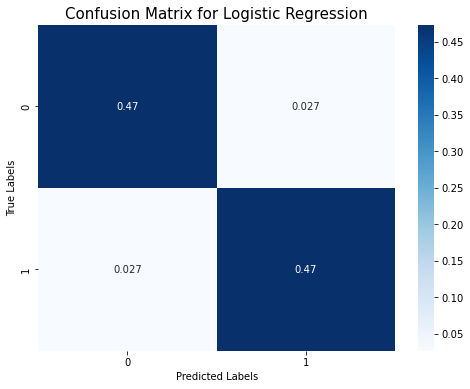

In [143]:
lgs_matrix=confusion_matrix(lgs_prediction, y_test, normalize='all')
plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(lgs_matrix, annot=True, ax = ax, cmap="Blues")
print(lgs_matrix)

ax.set_xlabel('Predicted Labels', size=10)
ax.set_ylabel('True Labels', size=10)
ax.set_title('Confusion Matrix for Logistic Regression', size=15)
ax.xaxis.set_ticklabels([0,1], size=10)
ax.yaxis.set_ticklabels([0,1], size=10);

In [145]:
russian_text = tfidf_vec.transform(true_sample["filtered_text"].fillna(' ').values)
russian_prediction = lgs_model.predict(russian_text)
print(f"Russian propaganda articles classified to as fake news: {russian_prediction.tolist().count(1)}")
print(f"Russian propaganda articles classified to as true news: {russian_prediction.tolist().count(0)}")
print(classification_report(lgs_prediction, y_test))

Russian propaganda articles classified to as fake news: 1333
Russian propaganda articles classified to as true news: 32667
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6807
           1       0.95      0.95      0.95      6793

    accuracy                           0.95     13600
   macro avg       0.95      0.95      0.95     13600
weighted avg       0.95      0.95      0.95     13600



In [147]:
true_text = tfidf_vec.transform(true_sample["filtered_text"].fillna(' ').values)
true_prediction = lgs_model.predict(russian_text)
true_correct = true_prediction.tolist().count(0)
true_false = true_prediction.tolist().count(1)
print(true_correct, true_false)

32667 1333


In [149]:
fake_text = tfidf_vec.transform(fake_sample["filtered_text"].fillna(' ').values)
fake_prediction = lgs_model.predict(fake_text)
fake_false = fake_prediction.tolist().count(0)
fake_correct = fake_prediction.tolist().count(1)
print(fake_correct, fake_false)

32698 1302


In [151]:
russian_text = tfidf_vec.transform(russian["filtered_text"].fillna(' ').values)
russian_prediction = lgs_model.predict(russian_text)
russian_false = russian_prediction.tolist().count(0)
russian_correct = russian_prediction.tolist().count(1)
print(russian_correct, russian_false)

5997 46


In [155]:
lgs_df = pd.DataFrame(columns=["News_Type", "True", "Fake"])
lgs_df.loc[len(lgs_df)] = ["True News", true_correct, true_false]
lgs_df.loc[len(lgs_df)] = ["Fake News", fake_false, fake_correct]
lgs_df.loc[len(lgs_df)] = ["Russian Propaganda", russian_false, russian_correct]
lgs_df["Model"] = "Logistic Regression"
lgs_df

,News_Type,True,Fake,Model
0,True News,32667,1333,Logistic Regression
1,Fake News,1302,32698,Logistic Regression
2,Russian Propaganda,46,5997,Logistic Regression


In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=11)
tfidf_vec = TfidfVectorizer()
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(tfidf_train.shape)
print(tfidf_test.shape)

(51200,) (12800,)
(51200,) (12800,)
(51200, 164247)
(12800, 164247)


In [203]:
lgs_model = LogisticRegression()
lgs_model.fit(tfidf_train, y_train)
lgs_prediction = lgs_model.predict(tfidf_test)
print('Accuracy testing on preprocessed test set after NLP filtering:',accuracy_score(y_test, lgs_prediction))

Accuracy testing on preprocessed test set after NLP filtering: 0.946328125


[[0.47242187 0.02609375]
 [0.02757812 0.47390625]]


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

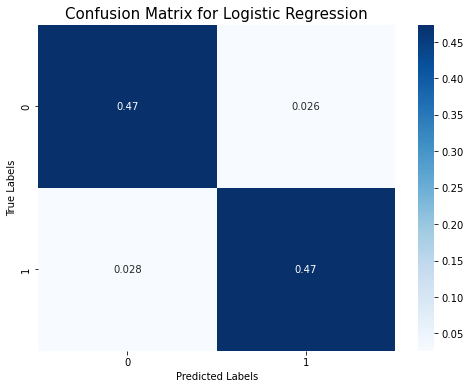

In [204]:
lgs_matrix=confusion_matrix(lgs_prediction, y_test, normalize='all')
plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(lgs_matrix, annot=True, ax = ax, cmap="Blues")
print(lgs_matrix)

ax.set_xlabel('Predicted Labels', size=10)
ax.set_ylabel('True Labels', size=10)
ax.set_title('Confusion Matrix for Logistic Regression', size=15)
ax.xaxis.set_ticklabels([0,1], size=10)
ax.yaxis.set_ticklabels([0,1], size=10)

### Support Vector Machine

In [28]:
svm_model=svm.SVC(kernel='linear')
svm_model.fit(tfidf_train, y_train)
svm_prediction = svm_model.predict(tfidf_test)
print('Accuracy testig on preprocessed test set:',accuracy_score(y_test, svm_prediction))

Accuracy testig on preprocessed test set: 0.9559558823529412


[[0.47933824 0.02338235]
 [0.02066176 0.47661765]]


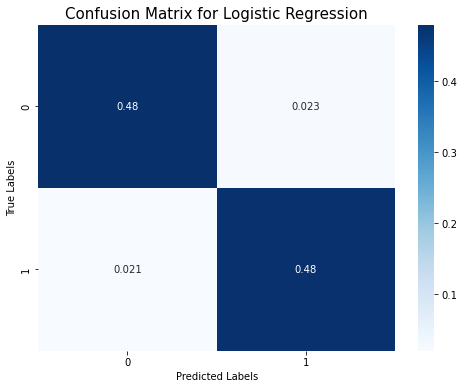

In [29]:
svm_matrix=confusion_matrix(svm_prediction, y_test, normalize='all')
plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(svm_matrix, annot=True, ax = ax, cmap="Blues")
print(svm_matrix)

ax.set_xlabel('Predicted Labels', size=10)
ax.set_ylabel('True Labels', size=10)
ax.set_title('Confusion Matrix for Support Vector Machine', size=15)
ax.xaxis.set_ticklabels([0,1], size=10)
ax.yaxis.set_ticklabels([0,1], size=10)

In [37]:
russian_text = tfidf_vec.transform(russian["text"].values)
russian_prediction = svm_model.predict(russian_text)
print(f"Russian propaganda articles classified to as fake news: {russian_prediction.tolist().count(1)}")
print(f"Russian propaganda articles classified to as true news: {russian_prediction.tolist().count(0)}")
print(classification_report(svm_prediction, y_test))

Russian propaganda articles classified to as fake news: 6043
Russian propaganda articles classified to as true news: 0
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      6837
           1       0.95      0.96      0.96      6763

    accuracy                           0.96     13600
   macro avg       0.96      0.96      0.96     13600
weighted avg       0.96      0.96      0.96     13600



In [152]:
svc_true_text = tfidf_vec.transform(true_sample["filtered_text"].fillna(' ').values)
svc_true_prediction = svm_model.predict(svc_true_text)
svc_true_correct = svc_true_prediction.tolist().count(0)
svc_true_false = svc_true_prediction.tolist().count(1)
print(svc_true_correct, svc_true_false)

33313 687


In [153]:
svc_fake_text = tfidf_vec.transform(fake_sample["filtered_text"].fillna(' ').values)
svc_fake_prediction = svm_model.predict(svc_fake_text)
svc_fake_false = svc_fake_prediction.tolist().count(0)
svc_fake_correct = svc_fake_prediction.tolist().count(1)
print(svc_fake_correct, svc_fake_false)

33220 780


In [154]:
svc_russian_text = tfidf_vec.transform(russian["filtered_text"].fillna(' ').values)
svc_russian_prediction = svm_model.predict(svc_russian_text)
svc_russian_false = svc_russian_prediction.tolist().count(0)
svc_russian_correct = svc_russian_prediction.tolist().count(1)
print(svc_russian_correct, svc_russian_false)

6007 36


In [159]:
svc_df = pd.DataFrame(columns=["News_Type", "True", "Fake"])
svc_df.loc[len(svc_df)] = ["True News", svc_true_correct, svc_true_false]
svc_df.loc[len(svc_df)] = ["Fake News", svc_fake_false, svc_fake_correct]
svc_df.loc[len(svc_df)] = ["Russian Propaganda", svc_russian_false, svc_russian_correct]
svc_df["Model"] = "Support Vector Machine"
svc_df

,News_Type,True,Fake,Model
0,True News,33313,687,Support Vector Machine
1,Fake News,780,33220,Support Vector Machine
2,Russian Propaganda,36,6007,Support Vector Machine


### Model Comparison

In [160]:
model_df = pd.concat([lgs_df, svc_df], axis=0)
display(model_df)

,News_Type,True,Fake,Model
0,True News,32667,1333,Logistic Regression
1,Fake News,1302,32698,Logistic Regression
2,Russian Propaganda,46,5997,Logistic Regression
0,True News,33313,687,Support Vector Machine
1,Fake News,780,33220,Support Vector Machine
2,Russian Propaganda,36,6007,Support Vector Machine


---

## Categorizing News Articles

In [228]:
category_raw = pd.read_csv("csv/bbc_news_train.csv")
display(category_raw.head())

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Load training dataset. This dataset is retrieved from [Kaggle](https://www.kaggle.com/competitions/learn-ai-bbc/data?select=BBC+News+Train.csv). 

In [229]:
category_raw = category_raw.rename(columns={"Text":"text"})
category_raw = cleanup_df(category_raw, "BBC News Category")
category_raw["filtered_text"] = category_raw["text"].apply(lambda x: remove_stopwords_and_lemmatize(x))
category_raw.head()

50 duplicated rows present in BBC News Category news dataset.
0 NaN row removed.
Total number of rows remaining are: 1440 rows.


,ArticleId,text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


,ArticleId,text,Category,filtered_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex-boss launch defence lawyer defend ...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll economic gloom citizen majority natio...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster funky h...
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss $ 168m payout eighteen enron direct...


In [232]:
X_category = category_raw["filtered_text"].fillna(' ')
y_category = category_raw["Category"].values
X_train, X_test, y_train, y_test = train_test_split(X_category, y_category, 
                                                    stratify=y_category, test_size=0.2, random_state=11)
tfidf_vec = TfidfVectorizer()
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1152,) (288,)
(1152,) (288,)


### Support Vector Machine

In [234]:
svm_model_for_category=svm.SVC(kernel='linear')
svm_model_for_category.fit(tfidf_train, y_train)
svm_prediction_for_category = svm_model_for_category.predict(tfidf_test)
print('Accuracy testing on pmulti-class linear SVC model:',accuracy_score(y_test, svm_prediction_for_category))
print(classification_report(svm_prediction_for_category, y_test))

Accuracy testing on pmulti-class linear SVC model: 0.9861111111111112
               precision    recall  f1-score   support

     business       0.99      1.00      0.99        66
entertainment       1.00      0.96      0.98        55
     politics       0.96      1.00      0.98        51
        sport       1.00      0.99      0.99        69
         tech       0.98      0.98      0.98        47

     accuracy                           0.99       288
    macro avg       0.99      0.99      0.99       288
 weighted avg       0.99      0.99      0.99       288



In [244]:
svc_category_text = tfidf_vec.transform(fake_sample["filtered_text"].fillna(' ').values)
svc_category_prediction = svm_model_for_category.predict(svc_category_text)
svc_business = svc_category_prediction.tolist().count("business")
svc_entertainment = svc_category_prediction.tolist().count("entertainment")
svc_poltiics = svc_category_prediction.tolist().count("politics")
svc_sport = svc_category_prediction.tolist().count("sport")
svc_tech = svc_category_prediction.tolist().count("tech")

In [246]:
svc_category_text_true = tfidf_vec.transform(true_sample["filtered_text"].fillna(' ').values)
svc_category_prediction_true = svm_model_for_category.predict(svc_category_text_true)
svc_business_true = svc_category_prediction_true.tolist().count("business")
svc_entertainment_true = svc_category_prediction_true.tolist().count("entertainment")
svc_poltiics_true = svc_category_prediction_true.tolist().count("politics")
svc_sport_true = svc_category_prediction_true.tolist().count("sport")
svc_tech_true = svc_category_prediction_true.tolist().count("tech")

### Logistic Regression

In [242]:
lgs_model_for_category=LogisticRegression()
lgs_model_for_category.fit(tfidf_train, y_train)
lgs_prediction_for_category = lgs_model_for_category.predict(tfidf_test)
print('Accuracy testing on pmulti-class Logistic Regression Model:',accuracy_score(y_test, lgs_prediction_for_category))
print(classification_report(lgs_prediction_for_category, y_test))

Accuracy testing on pmulti-class Logistic Regression Model: 0.9756944444444444
               precision    recall  f1-score   support

     business       0.97      0.98      0.98        66
entertainment       0.98      0.96      0.97        54
     politics       0.96      0.98      0.97        52
        sport       1.00      0.97      0.99        70
         tech       0.96      0.98      0.97        46

     accuracy                           0.98       288
    macro avg       0.97      0.98      0.97       288
 weighted avg       0.98      0.98      0.98       288



In [245]:
lgs_category_text = tfidf_vec.transform(fake_sample["filtered_text"].fillna(' ').values)
lgs_category_prediction = lgs_model_for_category.predict(lgs_category_text)
lgs_business = lgs_category_prediction.tolist().count("business")
lgs_entertainment = lgs_category_prediction.tolist().count("entertainment")
lgs_poltiics = lgs_category_prediction.tolist().count("politics")
lgs_sport = lgs_category_prediction.tolist().count("sport")
lgs_tech = lgs_category_prediction.tolist().count("tech")

In [251]:
lgs_category_text_true = tfidf_vec.transform(true_sample["filtered_text"].fillna(' ').values)
lgs_category_prediction_true = lgs_model_for_category.predict(lgs_category_text_true)
lgs_business_true = lgs_category_prediction_true.tolist().count("business")
lgs_entertainment_true = lgs_category_prediction_true.tolist().count("entertainment")
lgs_poltiics_true = lgs_category_prediction_true.tolist().count("politics")
lgs_sport_true = lgs_category_prediction_true.tolist().count("sport")
lgs_tech_true = lgs_category_prediction_true.tolist().count("tech")

### Natural Bayes Classifier

In [255]:
bayes_model_for_category = MultinomialNB()
bayes_model_for_category.fit(tfidf_train, y_train)
bayes_prediction_for_category = bayes_model_for_category.predict(tfidf_test)
print('Accuracy testing on pmulti-class Natural Bayes Model:',accuracy_score(y_test, bayes_prediction_for_category))
print(classification_report(bayes_prediction_for_category, y_test))

Accuracy testing on pmulti-class Natural Bayes Model: 0.9722222222222222
               precision    recall  f1-score   support

     business       0.99      0.96      0.97        69
entertainment       0.96      1.00      0.98        51
     politics       0.94      0.98      0.96        51
        sport       1.00      0.94      0.97        72
         tech       0.96      1.00      0.98        45

     accuracy                           0.97       288
    macro avg       0.97      0.98      0.97       288
 weighted avg       0.97      0.97      0.97       288



In [260]:
bayes_category_text = tfidf_vec.transform(fake_sample["filtered_text"].fillna(' ').values)
bayes_category_prediction = bayes_model_for_category.predict(bayes_category_text)
bayes_business = bayes_category_prediction.tolist().count("business")
bayes_entertainment = bayes_category_prediction.tolist().count("entertainment")
bayes_poltiics = bayes_category_prediction.tolist().count("politics")
bayes_sport = bayes_category_prediction.tolist().count("sport")
bayes_tech = bayes_category_prediction.tolist().count("tech")

In [261]:
bayes_category_text_true = tfidf_vec.transform(true_sample["filtered_text"].fillna(' ').values)
bayes_category_prediction_true = bayes_model_for_category.predict(bayes_category_text_true)
bayes_business_true = bayes_category_prediction_true.tolist().count("business")
bayes_entertainment_true = bayes_category_prediction_true.tolist().count("entertainment")
bayes_poltiics_true = bayes_category_prediction_true.tolist().count("politics")
bayes_sport_true = bayes_category_prediction_true.tolist().count("sport")
bayes_tech_true = bayes_category_prediction_true.tolist().count("tech")

### Model Comparison

In [264]:
category_df = pd.DataFrame(columns=["Model", "Business", "Entertainment", "Politics", "Sport", "Tech", "News Type", "Model Accuracy"])
category_df.loc[len(category_df)] = ["SVC", svc_business, svc_entertainment, svc_poltiics, svc_sport, svc_tech, "Fake", 0.98611]
category_df.loc[len(category_df)] = ["SVC", svc_business_true, svc_entertainment_true, svc_poltiics_true, 
                                     svc_sport_true, svc_tech_true, "True", 0.98611]
category_df.loc[len(category_df)] = ["Logistic Regression", lgs_business, lgs_entertainment, lgs_poltiics, lgs_sport, lgs_tech, "Fake", 0.97569]
category_df.loc[len(category_df)] = ["Logistic Regression", lgs_business_true, lgs_entertainment_true, lgs_poltiics_true, 
                                     lgs_sport_true, lgs_tech_true, "True", 0.97569]
category_df.loc[len(category_df)] = ["Natural Bayes", bayes_business, bayes_entertainment, bayes_poltiics, bayes_sport, bayes_tech, "Fake", 0.97222]
category_df.loc[len(category_df)] = ["Natural Bayes", bayes_business_true, bayes_entertainment_true, bayes_poltiics_true, 
                                     bayes_sport_true, bayes_tech_true, "True", 0.97222]
category_df

,Model,Business,Entertainment,Politics,Sport,Tech,News Type,Model Accuracy
0,SVC,13507,6293,10500,1505,2195,Fake,0.98611
1,SVC,14506,2770,15015,813,896,True,0.98611
2,Logistic Regression,13638,4004,9564,5218,1576,Fake,0.97569
3,Logistic Regression,15730,2219,13430,1887,734,True,0.97569
4,Natural Bayes,11210,1641,16412,3647,1090,Fake,0.97222
5,Natural Bayes,13685,1147,17414,1319,435,True,0.97222
